# 02_Model_Training_YOLOv5

Credits and Comments: 
- This notebook heavily leverages the templates provided by Roboflow.ai. 
- A few of the Roboflow images have been removed, and in many cases, I've added my own comments. If you are intending to use Roboflow's code, you would be better served by going directly to their website at roboflow.ai.
- This notebook is designed to run in Google Colab. It requires PyTorch and GPU hardware. Therefore, *this notebook is not likely to run on your local machine.*



## Contents
- How to Train YOLOv5 / project setup
- Install the custom dataset
- Define and build the model
    - The YOLOv5 model is easily built from a template; this is more space efficient than loading a saved model.
- Train the model on train and validation sets
- Evaluate the metrics from train/validation
- Run inference (prediction) on test images
- Save the model weights


## How to Train YOLOv5 on Custom Objects

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train YOLOv5 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference



### **About**

[Roboflow](https://roboflow.ai) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
#temporary until bug is fixed in current master
!git reset --hard 5ba1de0cdcc414c69ceb7a4c45eb1e3895eca32a
%cd /content

!pip install -r yolov5/requirements.txt  # install dependencies
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


# Download Correctly Formatted Custom Dataset 

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
# Export code snippet and paste here
%cd /content
#!curl -L "https://public.roboflow.ai/ds/YOUR DATASET HERE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# I used the following line, but have removed it from the notebook.
# I've also removed the output to avoid disclosing other secret info.
#!curl -L "https://app.roboflow.ai/----removed---------" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


In [3]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: [' ', '1', '2']

In [4]:
# Not sure why that data.yaml has bad names; I think I may have had it open while the data was being uploaded.
#  So far, I don't have the ability to fix my mistake on roboflow.ai, so I'll fix this by uploading a new file

from google.colab import files
uploaded = files.upload()

Saving data.yaml to data (1).yaml


In [6]:
%mv data.yaml bad_data.yaml
%mv data*.yaml data.yaml

In [7]:
# See if data.yaml looks correct now
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['unknown','adipose','no_adipose']


# Define Model Configuration and Architecture

Roboflow comments:
- We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.
- You do not need to edit these cells, but you may.

My comments: 
- Until other issues are resolved (better images, better labels, more images, etc.) I don't think that there is a reason to tweak the model.
- After other options are exhausted, if the model is not performing as well as I'd hoped, I will come back to this and experiment.

In [8]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:
%cd /content/
##write custom model .yaml
#you can configure this based on other YOLOv5 models in the models directory
with open('yolov5/models/custom_yolov5s.yaml', 'w') as f:
  # parameters
  f.write('nc: ' + num_classes + '\n')
  #f.write('nc: ' + str(len(class_labels)) + '\n')
  f.write('depth_multiple: 0.33'  + '\n') # model depth multiple
  f.write('width_multiple: 0.50'  + '\n')  # layer channel multiple
  f.write('\n')
  f.write('anchors:' + '\n')
  f.write('  - [10,13, 16,30, 33,23] ' + '\n')
  f.write('  - [30,61, 62,45, 59,119]' + '\n')
  f.write('  - [116,90, 156,198, 373,326] ' + '\n')
  f.write('\n')

  f.write('backbone:' + '\n')
  f.write('  [[-1, 1, Focus, [64, 3]],' + '\n')
  f.write('   [-1, 1, Conv, [128, 3, 2]],' + '\n')
  f.write('   [-1, 3, Bottleneck, [128]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 3, 2]],' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [256]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 3, 2]], ' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [512]],' + '\n')
  f.write('   [-1, 1, Conv, [1024, 3, 2]],' + '\n')
  f.write('   [-1, 1, SPP, [1024, [5, 9, 13]]],' + '\n')
  f.write('   [-1, 6, BottleneckCSP, [1024]],' + '\n')
  f.write('  ]' + '\n')
  f.write('\n')

  f.write('head:'  + '\n')
  f.write('  [[-1, 3, BottleneckCSP, [1024, False]],'  + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  
  f.write('   [[-1, 6], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [512, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  f.write('   [[-1, 4], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [256, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('\n' )
  f.write('   [[], 1, Detect, [nc, anchors]],' + '\n')
  f.write('  ]' + '\n')

print('custom model config written!')

/content
custom model config written!


# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [30]:
# train yolov5s on custom data for 50 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 500 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results --nosave --cache

/content/yolov5
Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Your branch is behind 'origin/master' by 85 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='../data.yaml', device='', epochs=500, evolve=False, img_size=[416], multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=True, notest=False, rect=False, resume=False, single_cls=False, weights='')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-07-11 00:12:46.731043: I tensorflow/stream_executor/platform/default/dso_loader.

**Discussion**

Wall time of 1h 12min 4s, as reported above, is a surprisingly fast training session for 500 epochs!
Based on the lack of significant model improvments from epoch 100 to epoch 500, there is no reason to think that additional epochs make sense at this time. Instead, closer inspection of the labels and gathering more image are more likely to improve the training.

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [11]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

Output hidden; open in https://colab.research.google.com to view.

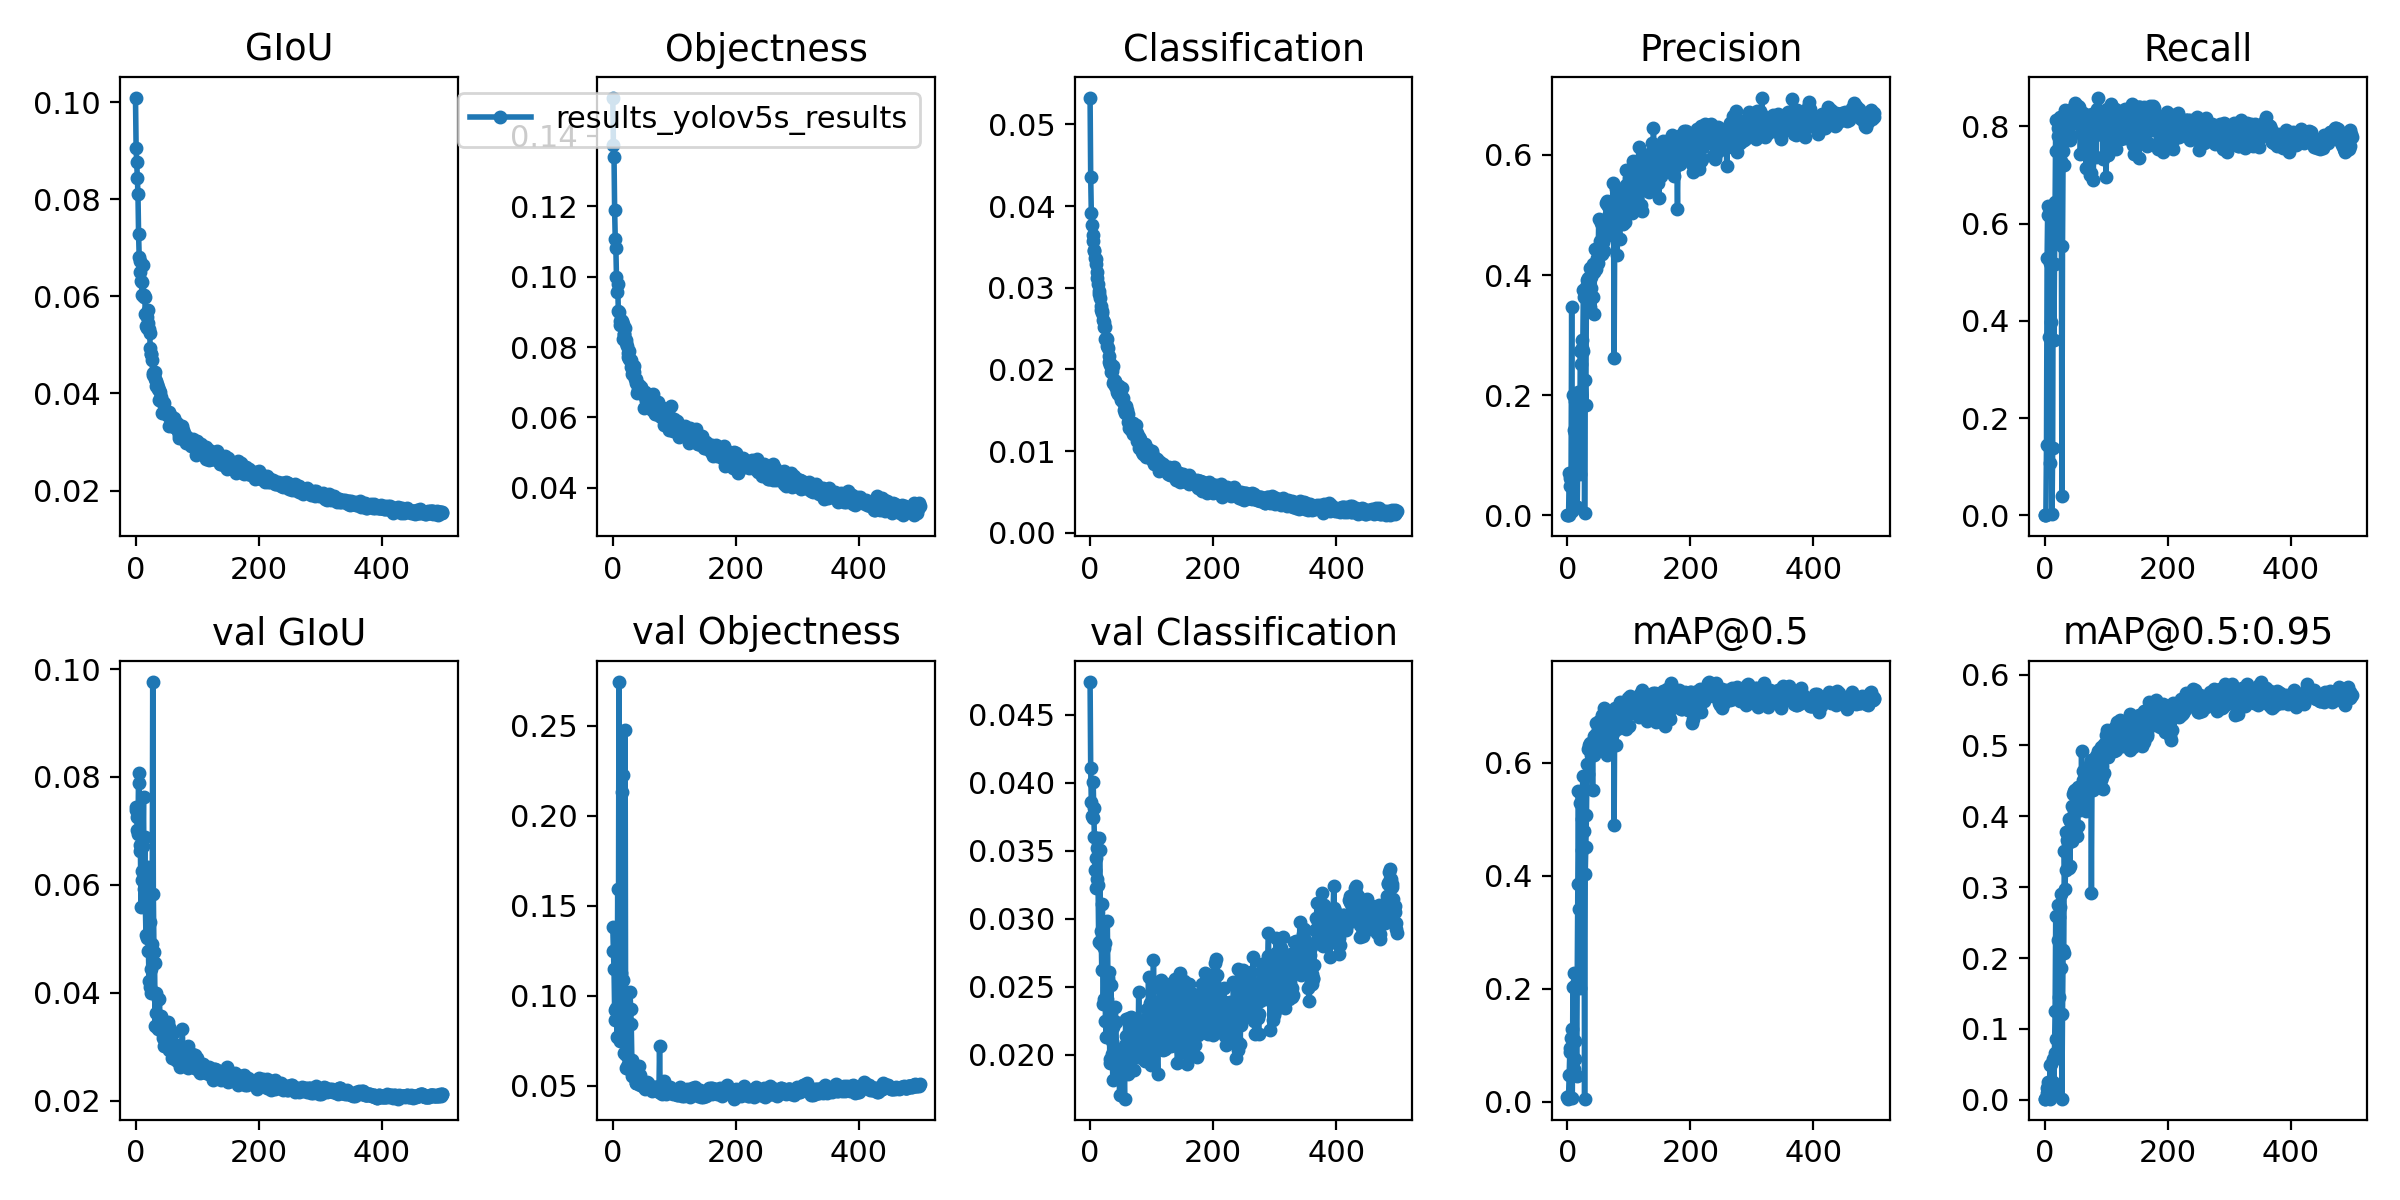

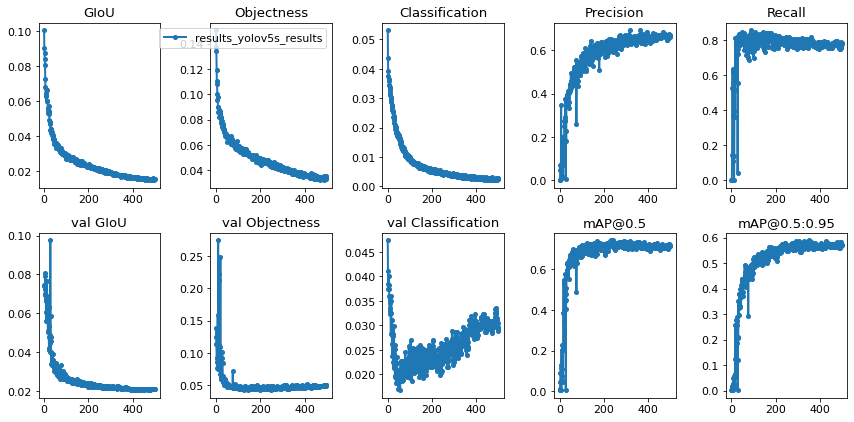

In [31]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.utils import plot_results; plot_results()  # plot results.txt as results.png
Image(filename='./results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

GROUND TRUTH TRAINING DATA:


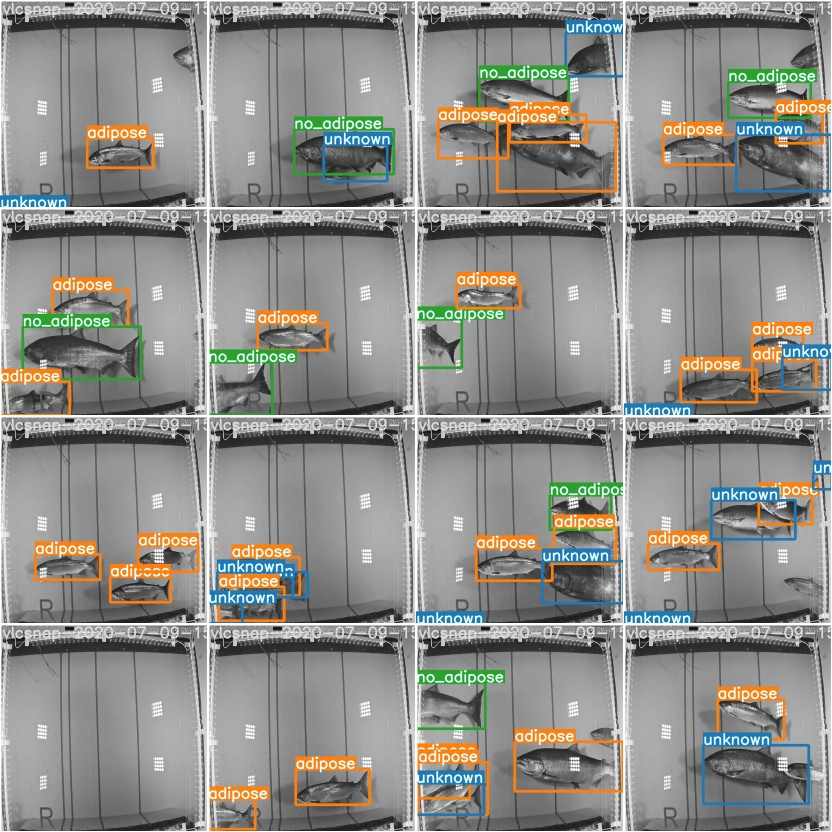

In [13]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='./test_batch0_gt.jpg', width=900)

My comment:
- Data augmentation was introduced to the CNN model family with AlexNet in 2012. Flipping, grayscale, and changing brightness are all easy to do with a script.
- Data augmentation for object detection also requires that the bounding boxes be translated, and that's a more complicated step.

GROUND TRUTH AUGMENTED TRAINING DATA:


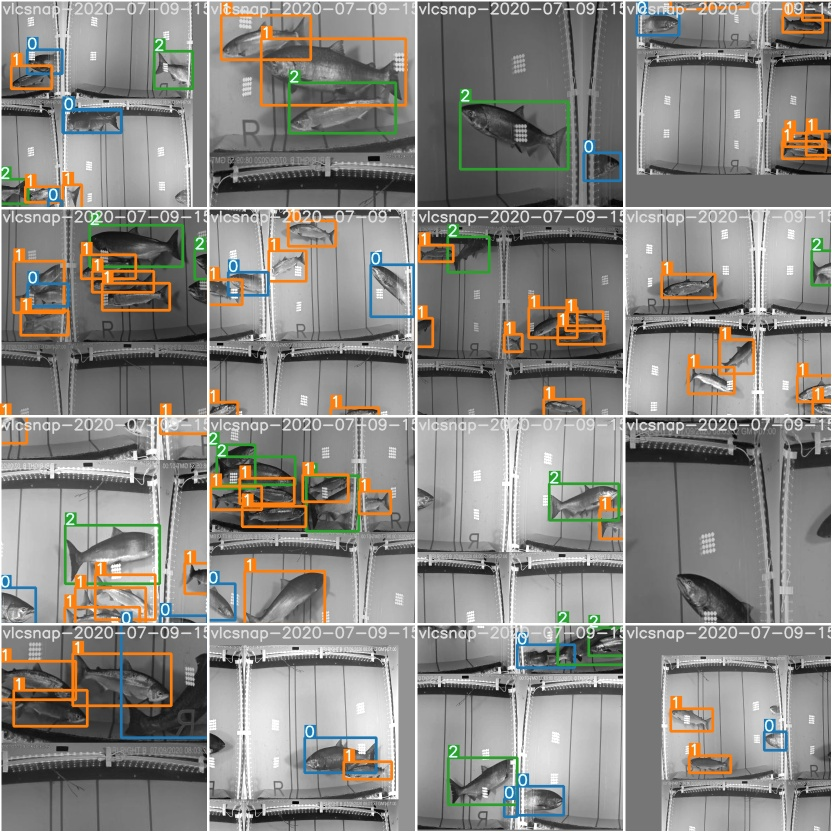

In [14]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='./train_batch2.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [15]:
# trained weights are saved by default in our weights folder
%ls weights/

download_weights.sh*  last_yolov5s_results.pt


In [32]:
# Comment from the chess image example: when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
%cd /content/yolov5/
!python detect.py --weights weights/last_yolov5s_results.pt --img 416 --conf 0.4 --source ../test/images


/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=416, iou_thres=0.5, output='inference/output', save_txt=False, source='../test/images', update=False, view_img=False, weights='weights/last_yolov5s_results.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

image 1/32 ../test/images/vlcsnap-2020-07-09-15h02m15s563_png.rf.e7a4532e051732194d411f47e2a0adae.jpg: 416x416 1 adiposes, 1 no_adiposes, Done. (0.011s)
image 2/32 ../test/images/vlcsnap-2020-07-09-15h02m23s647_png.rf.81d79063564109fd91f719d41da3ac78.jpg: 416x416 1 unknowns, 2 adiposes, Done. (0.010s)
image 3/32 ../test/images/vlcsnap-2020-07-09-15h02m50s295_png.rf.65a1f9b019ff0a3bced5c8293aa9adbf.jpg: 416x416 4 adiposes, Done. (0.012s)
image 4/32 ../test/images/vlcsnap-2020-07-09-15h02m55s882_png.rf.d61da792b258998a10c81971b069c287.jpg: 416x416 3 adiposes, Done. (0.014s)
image 5/32 ../test/images/vlcsnap-2020-07-09-15h03m24s697_png.rf.47b

Note that the inference on each image takes about 10 to 13 msec.

In [17]:
#display inference on ALL test images
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/inference/output/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

Output hidden; open in https://colab.research.google.com to view.

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [19]:
%cp /content/yolov5/weights/last_yolov5s_results.pt /content/gdrive/My\ Drive

In [22]:
%ls inference

images/  output/


In [24]:
%ls inference/output

vlcsnap-2020-07-09-15h02m15s563_png.rf.e7a4532e051732194d411f47e2a0adae.jpg
vlcsnap-2020-07-09-15h02m23s647_png.rf.81d79063564109fd91f719d41da3ac78.jpg
vlcsnap-2020-07-09-15h02m50s295_png.rf.65a1f9b019ff0a3bced5c8293aa9adbf.jpg
vlcsnap-2020-07-09-15h02m55s882_png.rf.d61da792b258998a10c81971b069c287.jpg
vlcsnap-2020-07-09-15h03m24s697_png.rf.47b9f272be5c5bf6f0ada1cbe3ac8f01.jpg
vlcsnap-2020-07-09-15h03m42s694_png.rf.d235386712d48444ffdf9c09d458295c.jpg
vlcsnap-2020-07-09-15h04m31s618_png.rf.cc419f25d5e77699fadc9948dc401ada.jpg
vlcsnap-2020-07-09-15h04m49s514_png.rf.5e74de8c15abe270a56fb2d836981f06.jpg
vlcsnap-2020-07-09-15h05m32s225_png.rf.6de5e772d248ee99663bfd8a0cbd2e9f.jpg
vlcsnap-2020-07-09-15h05m59s810_png.rf.33ae9e97cecf98c0c1fe32d0bd0c942e.jpg
vlcsnap-2020-07-09-15h06m10s548_png.rf.05fe869c65e2c48464c80e97d186ee65.jpg
vlcsnap-2020-07-09-15h06m51s572_png.rf.4e90fd8537dc51ba9fb84db415af52a8.jpg
vlcsnap-2020-07-09-15h06m56s339_png.rf.f8657ac0156daa1d5176fb6f66d1b8dd.jpg
vlcsnap-2020

In [35]:
%ls /content/gdrive/My\ Drive/GA_DSIR-420/Capstone_Project_6/RIS_fish_Roboflow-YOLOv5__inference_e500/


In [36]:
%cp inference/output/*.jpg /content/gdrive/My\ Drive/GA_DSIR-420/Capstone_Project_6/RIS_fish_Roboflow-YOLOv5__inference_e500/

On completion, the model weights were downloaded. New images can be re-run by using the 03* inference notebook.